<a href="https://colab.research.google.com/github/dkanzariya/Workshop/blob/main/MIMO_Fixed_Channel_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Deep MIMO Detection ( Fixed Channel )
https://arxiv.org/pdf/1706.01151.pdf

In [17]:
%tensorflow_version 1.x

import tensorflow as tf
import numpy as np
import time as tm
from tensorflow import keras
import matplotlib.pyplot as plt

print(tf.__version__)

1.15.2


In [2]:
def generate_data(B,K,N,snr_low,snr_high,H_org):
    # H_=np.random.randn(B,N,K)
    x_=np.sign(np.random.rand(B,K)-0.5)
    y_=np.zeros([B,N])
    w=np.random.randn(B,N)
    SNR_ = np.zeros([B])
    for i in range(B):

      SNR = np.random.uniform(low=snr_low,high=snr_high)
      H=H_org
      tmp_snr=(H.T.dot(H)).trace()/K
      y_[i,:]=(H.dot(x_[i,:])+w[i,:]*np.sqrt(tmp_snr)/np.sqrt(SNR))

      SNR_[i]=SNR

    return y_,x_,SNR_

In [4]:
K = 20
N = 30
B = 10000

low_snr_db_train = 7.0
high_snr_db_train = 14.0
low_snr_db_test = 8.0
high_snr_db_test = 13.0

num_snr = 6

H=np.genfromtxt('Top06_30_20.csv', dtype=None, delimiter=',')

#end of parameters

low_snr_train = 10.0 ** (low_snr_db_train/10.0)
high_snr_train = 10.0 ** (high_snr_db_train/10.0)
low_snr_test = 10.0 ** (low_snr_db_test/10.0)
high_snr_test = 10.0 ** (high_snr_db_test/10.0)

bers = np.zeros((1,num_snr))
loss = np.zeros((1,num_snr))


In [5]:
batch_Y, batch_X , SNR1 = generate_data(B , K , N , low_snr_train , high_snr_train , H)
print(H.shape)

(30, 20)


In [6]:
model = keras.Sequential()
model.add(keras.layers.Dense(200, input_shape=(N,),activation=tf.nn.relu))
for i in range(4):
    model.add(keras.layers.Dense(200,activation=tf.nn.relu))

h_final = model.add(keras.layers.Dense(K))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
model.compile(optimizer= tf.train.AdamOptimizer(), loss='mse', 
              metrics=[tf.keras.metrics.TruePositives()])

In [8]:
history=model.fit(batch_Y, batch_X, epochs=5)
model.evaluate(batch_Y,batch_X,10000)

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 2s 168us/sample - loss: 0.2797 - true_positives: 70158.0000
Epoch 2/5
10000/10000 [==============================] - 1s 125us/sample - loss: 0.1672 - true_positives: 82279.0000
Epoch 3/5
10000/10000 [==============================] - 1s 128us/sample - loss: 0.1535 - true_positives: 83872.0000
Epoch 4/5
10000/10000 [==============================] - 1s 131us/sample - loss: 0.1388 - true_positives: 85913.0000
Epoch 5/5
10000/10000 [==============================] - 0s 11us/sample - loss: 0.1022 - true_positives: 91227.0000


[0.10215491056442261, 91227.0]

In [9]:
# batch_Y[0].reshape(30,)
i = int(501)
print(batch_Y[i].shape)
x = np.expand_dims(batch_Y[i], axis=0)
Y = np.vstack([x])
classes = model.predict(Y,batch_size = 20)
model.summary()
result=np.where(classes > 0, 1, -1)
result=result.reshape(20,)
print(result)
X=batch_X[i].reshape(20,)
print(X)
print(X == result)


(30,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               6200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                4020      
Total params: 171,020
Trainable params: 171,020
Non-trainable params: 0
____________________________________________

In [10]:
#test data
test_iter = 1
tmp_bers = np.zeros((1,test_iter))
tmp_times = np.zeros((1,test_iter))
times = np.zeros((1,1))
testHitCount = 0

snr_list_db = np.linspace(low_snr_db_test,high_snr_db_test,num_snr)
snr_list = 10.0**(snr_list_db/10.0)

In [11]:
loss = []
bers = []

for i_snr in range (num_snr):
  Cur_SNR = snr_list[i_snr]
  print ('cur snr')
  print (Cur_SNR)
  
  for i in range (test_iter):
    batch_Y, batch_X , SNR1= generate_data(B , K , N , Cur_SNR , Cur_SNR , H)
    tic = tm.time()
    [loss,acc] = model.evaluate(batch_Y,batch_X)
    tmp_bers[0][i] = acc
    # print(tmp_bers)
    toc = tm.time()
    tmp_times[0][i] = toc-tic
  cnt= float(np.mean(tmp_bers[0]))
  bers.append([cnt])

print(bers)

cur snr
6.309573444801933
10000/10000 [==============================] - 0s 47us/sample - loss: 0.2141 - true_positives: 82925.0000
cur snr
7.943282347242816
10000/10000 [==============================] - 0s 43us/sample - loss: 0.1744 - true_positives: 84662.0000
cur snr
10.0
10000/10000 [==============================] - 0s 42us/sample - loss: 0.1418 - true_positives: 87119.0000
cur snr
12.589254117941675
10000/10000 [==============================] - 0s 45us/sample - loss: 0.1181 - true_positives: 89311.0000
cur snr
15.848931924611133
10000/10000 [==============================] - 0s 44us/sample - loss: 0.0989 - true_positives: 90950.0000
cur snr
19.952623149688797
10000/10000 [==============================] - 0s 44us/sample - loss: 0.0843 - true_positives: 92223.0000
[[82925.0], [84662.0], [87119.0], [89311.0], [90950.0], [92223.0]]


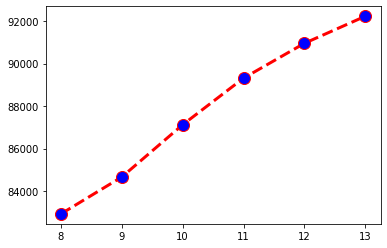

In [12]:
# bers =  bers/(K*B)
# bers = 1- bers
bers = np.reshape(bers,(6,))
snrdb_list = np.linspace(low_snr_db_test,high_snr_db_test,num_snr)
plt.plot(snrdb_list,bers,color='red', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12)
plt.show() 

In [13]:
times[0][0] = np.mean(tmp_times[0])/B
print ('Average time to detect a single K bit signal is:')
print (times)
ber =  bers/(K*B*5)
be = 1 - ber
print('snrdb_list')
print(snrdb_list)
print ('Bit error rates are is:')
print(ber)

Average time to detect a single K bit signal is:
[[4.43989992e-05]]
snrdb_list
[ 8.  9. 10. 11. 12. 13.]
Bit error rates are is:
[0.082925 0.084662 0.087119 0.089311 0.09095  0.092223]


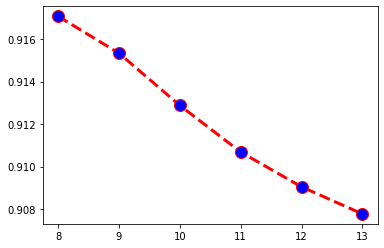

In [14]:
be = np.reshape(be,(6,))
snrdb_list = np.linspace(low_snr_db_test,high_snr_db_test,num_snr)
plt.plot(snrdb_list,be,color='red', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12)
plt.show() 

In [15]:
i = int(1066)
x = np.expand_dims(batch_Y[i], axis=0)
Y = np.vstack([x])
classes = model.predict(Y,batch_size = 20)
result=np.where(classes > 0, 1, -1)
result=result.reshape(20,)
print(result)
X=batch_X[i].reshape(20,)
print(X)
print(X == result)

[-1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1 -1 -1  1  1  1 -1]
[-1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1.  1.  1.
  1. -1.]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
